## Imports

In [ ]:
import torch
from torch import nn, optim
from torchvision import models, transforms

import numpy as np
from PIL import Image

## Data

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
transformer = transforms.Compose([
    transforms.Resize((324, 324)),
    transforms.ToTensor()
])

In [31]:
def load_image(image_path):
    image = Image.open(image_path)
    transformed_img = transformer(image).to(device)
    
    return transformed_img.unsqueeze(0)   

In [32]:
content_img = load_image('content.png')
style_img = load_image('style.png')
generated_img = load_image('content.png')
generated_img.requires_grad = True

## Model

In [33]:
model = models.vgg19(pretrained=True)

e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [35]:
class VGGNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.vgg = model.features
        self.style_out = [0, 5, 10, 19, 28]
        self.content_out = [30]

    def forward(self, x):

        style_out_values = []
        content_out_value = [] 

        for idx, layer in enumerate(self.vgg):
            x = layer(x)

            if idx in self.style_out:
                style_out_values.append(x)
            
            elif idx in self.content_out:
                content_out_value.append(x)

        
        return content_out_value, style_out_values 



In [36]:
model = VGGNet().to(device).eval()

## Style Transfer

In [37]:
LR = 0.001
EPOCHS = 600
optimizer = optim.Adam([generated_img], lr = LR)
style_weight = 1
content_weight = 1

In [38]:
conimg_content, conimg_style = model(content_img)
styleimg_content, styleimg_style = model(style_img)

In [39]:
for epoch in range(EPOCHS):

    genimg_content, genimg_style = model(generated_img)

    content_loss = torch.mean((genimg_content[0] - conimg_content[0])**2)

    style_loss = 0

    for gen_s, style_s in zip(genimg_style, styleimg_style):

        batch, channel, width, height = gen_s.shape

        gen_s_2d = gen_s.view(channel, width*height)
        style_s_2d = style_s.view((channel, width*height))

        gen_s_gram = torch.mm(gen_s_2d, gen_s_2d.t())
        style_s_gram = torch.mm(style_s_2d, style_s_2d.t())

        style_loss += torch.mean((gen_s_gram - style_s_gram)**2) / (channel * width * height)

        
    loss = content_weight * content_loss + style_weight * style_loss 
    print(f'epoch {epoch}: loss = {loss}')
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    


epoch 0: loss = 103.68896484375
epoch 1: loss = 102.15164184570312
epoch 2: loss = 100.65435028076172
epoch 3: loss = 99.15541076660156
epoch 4: loss = 97.62348175048828
epoch 5: loss = 96.0363540649414
epoch 6: loss = 94.38362884521484
epoch 7: loss = 92.65594482421875
epoch 8: loss = 90.8562240600586
epoch 9: loss = 88.99109649658203
epoch 10: loss = 87.07317352294922
epoch 11: loss = 85.1186294555664
epoch 12: loss = 83.141845703125
epoch 13: loss = 81.14605712890625
epoch 14: loss = 79.13832092285156
epoch 15: loss = 77.11565399169922
epoch 16: loss = 75.0820541381836
epoch 17: loss = 73.0453109741211
epoch 18: loss = 71.01546478271484
epoch 19: loss = 69.00235748291016
epoch 20: loss = 67.01398468017578
epoch 21: loss = 65.05921173095703
epoch 22: loss = 63.147186279296875
epoch 23: loss = 61.2768669128418
epoch 24: loss = 59.45307540893555
epoch 25: loss = 57.67750930786133
epoch 26: loss = 55.952674865722656
epoch 27: loss = 54.2780876159668
epoch 28: loss = 52.65604019165039
ep

## Result

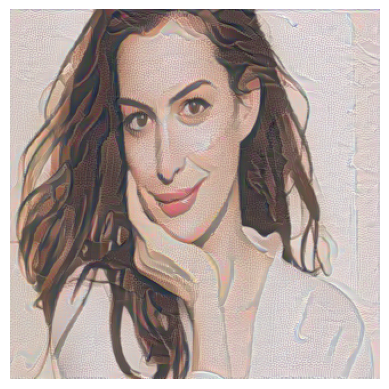

In [42]:
import matplotlib.pyplot as plt
import numpy as np

generated_img_np = generated_img.detach().cpu().numpy()
generated_img_np = generated_img_np.squeeze()

generated_img_np = (generated_img_np - generated_img_np.min()) / (generated_img_np.max() - generated_img_np.min())

plt.imshow(np.transpose(generated_img_np, (1, 2, 0)))
plt.axis('off')
plt.show()

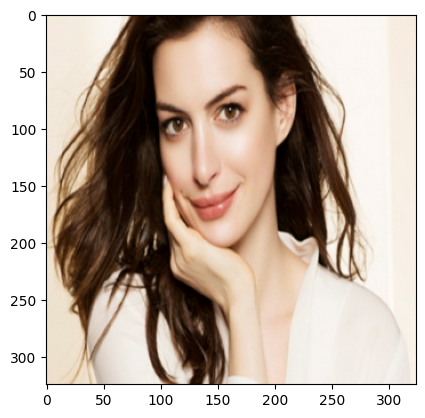

In [43]:
content_img_np = content_img.detach().cpu().numpy()
content_img_np = content_img_np.squeeze()

content_img_np = (content_img_np - content_img_np.min()) / (content_img_np.max() - content_img_np.min())

plt.imshow(np.transpose(content_img_np, (1, 2, 0)))

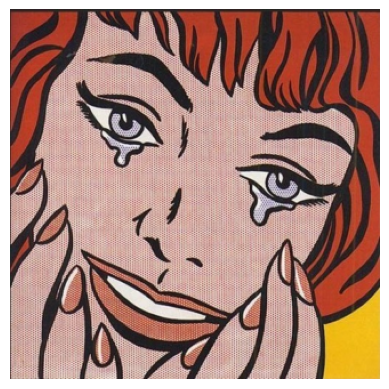

In [44]:
import matplotlib.pyplot as plt
import numpy as np

style_img_np = style_img.detach().cpu().numpy()
style_img_np = style_img_np.squeeze()

style_img_np = (style_img_np - style_img_np.min()) / (style_img_np.max() - style_img_np.min())

plt.imshow(np.transpose(style_img_np, (1, 2, 0)))
plt.axis('off')
plt.show()